In [1]:
import os
import csv
import time
import imageio
import shutil
import scipy.io
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.image import imread
from scipy.integrate import quad
from collections import Counter, defaultdict

import solver.conditions as conditions
import solver.utils as utils
import solver.pinn as pinn
import solver.pde as pde
import solver.siren as siren
import solver.metrics as metrics
import solver.geometry as geometry
import solver.timedomain as timedomain
import solver.visualizations as visualizations

import warnings
warnings.filterwarnings("ignore")

### Formulation of problem

In [2]:
def initial_condition_function(x):
    return torch.sin(torch.pi * torch.tensor(x))

def boundary_condition_function(x, t):
    return torch.sin(torch.pi * torch.tensor(t))

# def boundary_condition_function(x, t):
#     return torch.zeros_like(x)

def analytical_solution(x, t, alpha, L):
    x = torch.tensor(x)
    t = torch.tensor(t)
    u = torch.zeros_like(x)

    for n in range(1, 100):
        B_n, _ = quad(lambda x: initial_condition_function(x) * np.sin(n * np.pi * x / L), 0, L)
        u += 2 / L * B_n * torch.sin(n * np.pi * x / L) * torch.exp(-alpha**2 * (n * np.pi / L)**2 * t)
    return u

# def analytical_solution(x, t, alpha, L):
#     """
#     for u_0 = sin(pi * x) and u_b = sin(pi * t)
#     """
#     x = torch.tensor(x)
#     t = torch.tensor(t)
#     u = torch.sin(np.pi * x) * torch.exp(-np.pi**2 * alpha**2 * t) + torch.sin(np.pi * t)
#     return u

def fdm_solver(problem, Nx, last_only=False):
    L = problem.geom.length()
    T = problem.period.t1
    a = problem.alpha

    dx = L / (Nx - 1)
    dt = dx ** 2 / (4 * a)

    x = torch.linspace(0, 1, Nx)
    Nt = int(T / dt)
    t = torch.linspace(0, 0.5, Nt)

    u = torch.zeros((Nt, Nx))
    u[0, :] = problem.initial_conditions.initial_func(x)

    for n in range(Nt - 1):
        for i in range(1, Nx - 1):
            u[n + 1, i] = u[n, i] + a * dt / dx**2 * (u[n, i + 1] - 2 * u[n, i] + u[n, i - 1])
        u[n + 1, 0] = problem.boundary_conditions.boundary_func(x[0], t[n + 1])
        u[n + 1, -1] = problem.boundary_conditions.boundary_func(x[-1], t[n + 1])

    if last_only:
        return u[-1, :]
    else:
        x, t = torch.meshgrid(x, t)
        u = u.permute(1, 0)
        return x, t, u

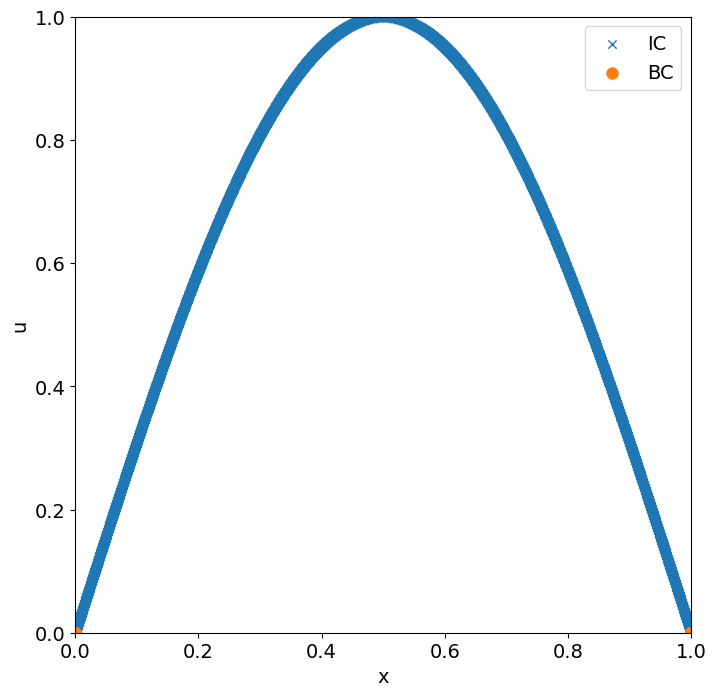

In [3]:
geom = geometry.Interval(0.0, 1.0)
period = timedomain.TimeDomain(0.0, 0.5)

initial_conditions = conditions.InitialConditions()
initial_conditions.set_initial_conditions(geom=geom, time=period, 
                                          initial_func=initial_condition_function, 
                                          num_points=10000, random=False, device="cuda:0")
x, t, u = initial_conditions.get_initial_conditions()

boundary_conditions = conditions.BoundaryConditions()
boundary_conditions.set_boundary_conditions(geom=geom, time=period, 
                                            boundary_func=boundary_condition_function, 
                                            num_points=10000, random=False, device="cuda:0")
x, t, u = boundary_conditions.get_boundary_conditions()

alpha = 0.5
pde_heat = pde.PDE('heat', alpha=alpha)

equation = conditions.Equation()
equation.set_equation(pde=pde_heat, geom=geom, time=period, num_points=10000, random=False, device="cuda:0")
x, t = equation.get_equation_points()

test = conditions.Test()
test.set_test(geom=geom, time=period, num_points=10000, random=False, device="cuda:0")
x, t = test.get_test()

problem = conditions.Problem(initial_conditions, boundary_conditions, 
                             equation, test, geom, period, alpha=alpha)

visualizations.conditions_plot(problem, t=0.0)

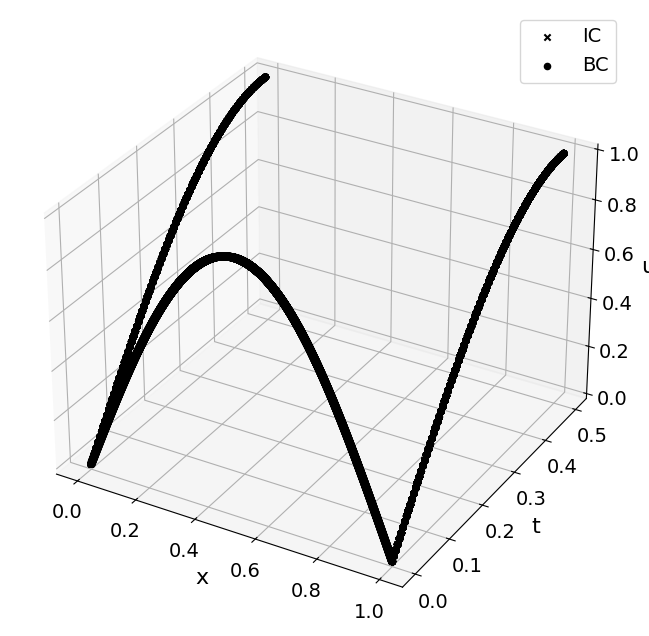

In [4]:
# x_initial, t_initial, u_initial = problem.initial_conditions.get_initial_conditions()
# x_boundary, t_boundary, u_boundary = problem.boundary_conditions.get_boundary_conditions()

# TODO: Make comparison with analytical solution
# x_equation = torch.linspace(0, 1, 100)
# t_equation = torch.linspace(0, 0.5, 100)
# x_equation, t_equation = torch.meshgrid(x_equation, t_equation)
# u_equation = analytical_solution(x_equation, t_equation, 0.1, 1)

# x_equation, t_equation, u_equation = fdm_solver(problem=problem, Nx=100)
# solution = conditions.Solution()
# solution.set_solution(x_equation, t_equation, u_equation)

visualizations.solution_surface_plot(problem, None)

## Tests

### Common functions

In [25]:
def average_loss(output_path, base_name, out_name):
    loss_data = {}
    time_data = {}
    
    for n in range(10):
        file_name = f"{base_name}{n}.csv"
        file_path = os.path.join(output_path, file_name)
        if os.path.isfile(file_path):
            with open(file_path, 'r') as file:
                for line in file:
                    parts = line.strip().split(',')
                    iteration = int(parts[0])
                    loss = float(parts[1])
                    time = float(parts[2])
                    
                    if iteration not in loss_data:
                        loss_data[iteration] = []
                        time_data[iteration] = []
                    
                    loss_data[iteration].append(loss)
                    time_data[iteration].append(time)

    average_loss_data = {iteration: np.mean(losses) for iteration, losses in loss_data.items()}
    average_time_data = {iteration: np.mean(times) for iteration, times in time_data.items()}
    
    max_iteration = max(average_loss_data.keys(), default=0)
    new_file_path = os.path.join(output_path, out_name)
    with open(new_file_path, 'w') as new_file:
        new_file.write("Iteration, Average_Loss, Average_Time\n")
        for iteration in range(100, max_iteration + 1, 100):
            if iteration in average_loss_data:
                avg_loss = average_loss_data[iteration]
                avg_time = average_time_data[iteration]
            else:
                max_iter = max(average_loss_data.keys(), default=0)
                avg_loss = average_loss_data[max_iter]
                avg_time = average_time_data[max_iter]
            
            new_file.write(f"{iteration}, {avg_loss}, {avg_time}\n")

In [21]:
def plot_loss(output_path):
    files = os.listdir(output_path)
    scheduler_files = [file for file in files if file.endswith('.csv')]
    schedulers_data = {}

    for file_name in scheduler_files:
        scheduler_name = file_name.split('_')[-1].split('.')[0]
        file_path = os.path.join(output_path, file_name)
        with open(file_path, 'r') as file:
            data = [tuple(map(float, line.strip().split(', '))) for line in file]
            schedulers_data[scheduler_name] = data

    plt.figure(figsize=(15, 10))
    for scheduler_name, data in schedulers_data.items():
        iterations, losses = zip(*data)
        plt.plot(iterations, losses, label=scheduler_name)

    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss for Different Schedulers')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_path, 'scheduler_loss.png'))
    plt.show()

### Scheduler importance test

In [7]:
def run_training(runs):
    for i in range(runs):
        net_params = utils.NetParams()
        net_params.set_params(input=2,
                            output=1,
                            hidden_layers=[int(20) for _ in range(2)],
                            epochs=3000,
                            batch_size=100,
                            lr=0.003,
                            activation='tanh',
                            training_mode='train',
                            regularization='no',
                            lambda_reg=None,
                            optimizer='Adam', # 'LBFGS', 'Adam' or 'Hybrid'
                            scheduler=None, # Not applicable with Hybrid optimizer
                            # 'StepLR', 'ExponentialLR', 'ReduceLROnPlateau' is supported
                            early_stopping=True,
                            use_rar=False,
                            use_weights_adjuster=False,
                            display_interval=100,
                            model_save_path='models',
                            output_path='out',
                            save_loss=True,
                            initial_weights_path=None, # 'models/model_weights.pth'
                            siren_params=None)
        
        model = pinn.PINN(problem, net_params, device='cuda:0')
        model.train()

In [ ]:
run_training(10)

In [ ]:
average_loss('out', 'HL_2_A_Tanh()_N_20_', 'HL_2_A_Tanh()_N_20_avg_scheduler_None.csv')

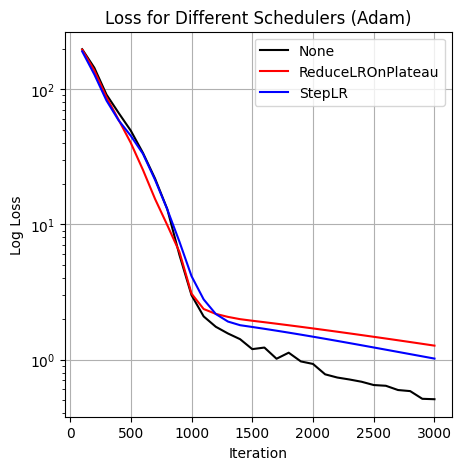

In [ ]:
import os
import pandas as pd

data_adam_none = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/schedulers/20x2_epoch3000_lr0_003_tanh_adam/HL_2_A_Tanh()_N_20_avg_scheduler_None.csv'))
data_adam_reduce = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/schedulers/20x2_epoch3000_lr0_003_tanh_adam/HL_2_A_Tanh()_N_20_avg_scheduler_ReduceLROnPlateau.csv'))
data_adam_step = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/schedulers/20x2_epoch3000_lr0_003_tanh_adam/HL_2_A_Tanh()_N_20_avg_scheduler_StepLR.csv'))

plt.figure(figsize=(5, 5))
plt.plot(data_adam_none['iteration'], data_adam_none['loss'], label='None', c='black')
plt.plot(data_adam_reduce['iteration'], data_adam_reduce['loss'], label='ReduceLROnPlateau', c='red')
plt.plot(data_adam_step['iteration'], data_adam_step['loss'], label='StepLR', c='blue')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.yscale('log')
plt.title('Loss for Different Schedulers (Adam)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(os.getcwd(), 'docs', 'tests', 'schedulers', 'scheduler_loss_adam.png'))
plt.show()

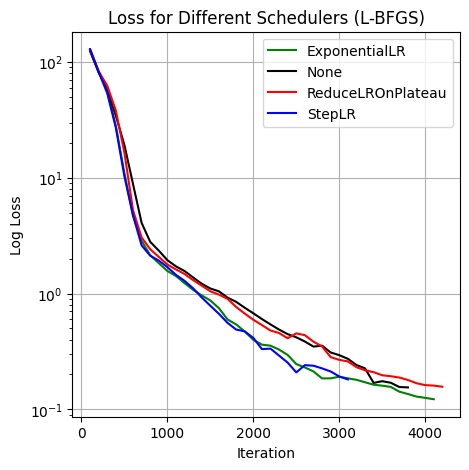

In [ ]:
data_lbfgs_none = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/schedulers/20x2_epoch3000_lr0_003_tanh_lbfgs/HL_2_A_Tanh()_N_20_avg_scheduler_None.csv'))
data_lbfgs_reduce = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/schedulers/20x2_epoch3000_lr0_003_tanh_lbfgs/HL_2_A_Tanh()_N_20_avg_scheduler_ReduceLROnPlateau.csv'))
data_lbfgs_step = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/schedulers/20x2_epoch3000_lr0_003_tanh_lbfgs/HL_2_A_Tanh()_N_20_avg_scheduler_StepLR.csv'))
data_lbfgs_exp = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/schedulers/20x2_epoch3000_lr0_003_tanh_lbfgs/HL_2_A_Tanh()_N_20_avg_scheduler_ExponentialLR.csv'))

plt.figure(figsize=(5, 5))
plt.plot(data_lbfgs_exp['iteration'], data_lbfgs_exp['loss'], label='ExponentialLR', c='green')
plt.plot(data_lbfgs_none['iteration'], data_lbfgs_none['loss'], label='None', c='black')
plt.plot(data_lbfgs_reduce['iteration'], data_lbfgs_reduce['loss'], label='ReduceLROnPlateau', c='red')
plt.plot(data_lbfgs_step['iteration'], data_lbfgs_step['loss'], label='StepLR', c='blue')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.yscale('log')
plt.title('Loss for Different Schedulers (L-BFGS)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(os.getcwd(), 'docs', 'tests', 'schedulers', 'scheduler_loss_lbfgs.png'))
plt.show()

### Optimizer influence

In [33]:
def run_training(runs):
    siren_params = siren.SirenParams(first_omega_0 = 30.0,
                                 hidden_omega_0 = 30.0,
                                 outermost_linear = True)
    
    for i in range(runs):
        net_params = utils.NetParams()
        net_params.set_params(input=2,
                            output=1,
                            hidden_layers=[int(64) for _ in range(1)],
                            epochs=5000,
                            batch_size=100,
                            lr=0.001,
                            activation='sin',
                            training_mode='train',
                            regularization='no',
                            lambda_reg=None,
                            optimizer='LBFGS', # 'LBFGS', 'Adam' or 'Hybrid'
                            scheduler=None, # Not applicable with Hybrid optimizer
                            # 'StepLR', 'ExponentialLR', 'ReduceLROnPlateau' is supported
                            early_stopping=True,
                            use_rar=False,
                            use_weights_adjuster=False,
                            display_interval=100,
                            model_save_path='models',
                            output_path='out',
                            save_loss=True,
                            initial_weights_path=None, # 'models/model_weights.pth'
                            siren_params=siren_params)
        
        model = pinn.PINN(problem, net_params, device='cuda:0')
        model.train()

In [34]:
run_training(10)

1
Activation Function: Sin
Hidden Dimensions: 1
Number of neurons: 64
----------
Layer 0: SineLayer(
  (linear): Linear(in_features=2, out_features=64, bias=True)
) -> Linear
Layer 1: Linear(in_features=64, out_features=1, bias=True)
----------
Next number: 0
Oprtimizer: LBFGS
Iteration 100: Loss 0.20376762747764587, Weighted Loss 258.7720947265625, Time 0.9434435367584229
Iteration 200: Loss 0.028267737478017807, Weighted Loss 36.57311248779297, Time 1.6167213916778564
Iteration 300: Loss 0.009313954040408134, Weighted Loss 10.789527893066406, Time 2.41384220123291
Iteration 400: Loss 0.004997231997549534, Weighted Loss 5.428639888763428, Time 3.4024009704589844
Iteration 500: Loss 0.003018416929990053, Weighted Loss 3.3629889488220215, Time 4.284283876419067
Iteration 600: Loss 0.0017268555238842964, Weighted Loss 2.119877338409424, Time 5.246136426925659
Iteration 700: Loss 0.0010361543390899897, Weighted Loss 1.4917006492614746, Time 6.165019273757935
Iteration 800: Loss 0.00080393

In [35]:
average_loss('out', 'HL_1_A_Sin()_N_64_', 'HL_1_A_Sin()_N_64_avg_optimizer_LBFGS.csv')

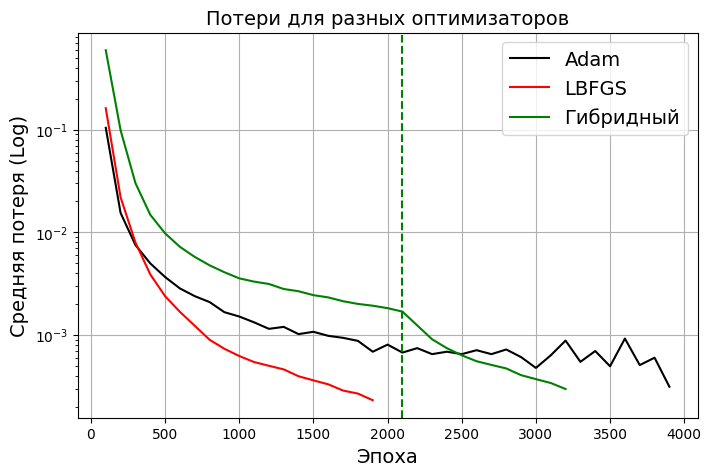

In [63]:
import os
import pandas as pd

data_adam = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/optimizers/HL_1_A_Sin()_N_64_avg_optimizer_Adam.csv'))
data_lbfgs = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/optimizers/HL_1_A_Sin()_N_64_avg_optimizer_LBFGS.csv'))
data_hybrid = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/optimizers/HL_1_A_Sin()_N_64_avg_optimizer_Hybrid.csv'))

plt.figure(figsize=(8, 5))
plt.plot(data_adam['Iteration'], data_adam['Average_Loss'], label='Adam', c='black')
plt.plot(data_lbfgs['Iteration'], data_lbfgs['Average_Loss'], label='LBFGS', c='red')
plt.plot(data_hybrid['Iteration'], data_hybrid['Average_Loss'], label='Гибридный', c='green')
plt.axvline(x=2100, color='green', linestyle='--')
plt.xlabel('Эпоха', fontsize=14)
plt.ylabel('Средняя потеря (Log)', fontsize=14)
plt.yscale('log')
plt.title('Потери для разных оптимизаторов', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.savefig(os.path.join(os.getcwd(), 'docs', 'tests', 'optimizers', 'optimizer_loss.png'))
plt.show()

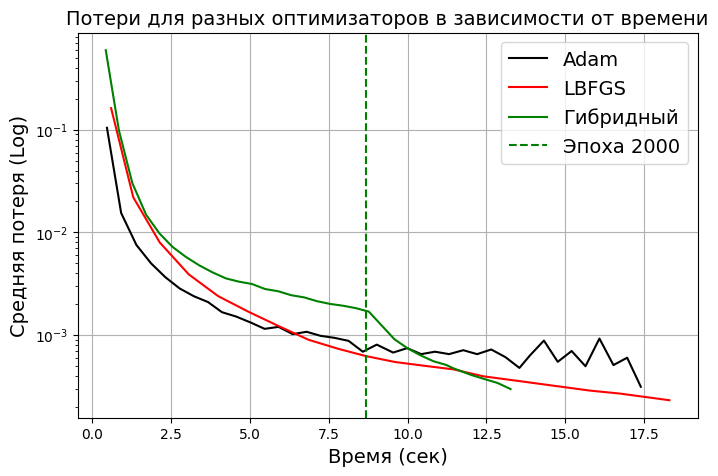

In [64]:
plt.figure(figsize=(8, 5))
plt.plot(data_adam['Average_Time'], data_adam['Average_Loss'], label='Adam', c='black')
plt.plot(data_lbfgs['Average_Time'], data_lbfgs['Average_Loss'], label='LBFGS', c='red')
plt.plot(data_hybrid['Average_Time'], data_hybrid['Average_Loss'], label='Гибридный', c='green')
plt.axvline(x=8.678190231323242, color='green', linestyle='--', label='Эпоха 2000')
plt.xlabel('Время (сек)', fontsize=14)
plt.ylabel('Средняя потеря (Log)', fontsize=14)
plt.yscale('log')
plt.title('Потери для разных оптимизаторов в зависимости от времени', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.savefig(os.path.join(os.getcwd(), 'docs', 'tests', 'optimizers', 'optimizer_loss_vs_time.png'))
plt.show()

In [ ]:
plot_loss('out')

### WeightAdjuster test

In [ ]:
def run_training(runs):
    for i in range(runs):
        net_params = utils.NetParams()
        net_params.set_params(input=2,
                            output=1,
                            hidden_layers=[int(20) for _ in range(2)],
                            epochs=3000,
                            batch_size=100,
                            lr=0.003,
                            activation='tanh',
                            training_mode='train',
                            regularization='no',
                            lambda_reg=None,
                            optimizer='Adam', # 'LBFGS', 'Adam' or 'Hybrid'
                            scheduler=None, # Not applicable with Hybrid optimizer
                            # 'StepLR', 'ExponentialLR', 'ReduceLROnPlateau' is supported
                            early_stopping=False,
                            use_rar=False,
                            use_weights_adjuster=True,
                            display_interval=100,
                            model_save_path='models',
                            output_path='out',
                            save_loss=True,
                            initial_weights_path=None, # 'models/model_weights.pth'
                            siren_params=None)
        
        model = pinn.PINN(problem, net_params, device='cuda:0')
        model.train()

In [ ]:
run_training(10)

Activation Function: Tanh
Hidden Dimensions: 2
Number of neurons: 20
----------
Layer 0: Linear(in_features=2, out_features=20, bias=True) -> Tanh
Layer 1: Linear(in_features=20, out_features=20, bias=True) -> Tanh
Layer 2: Linear(in_features=20, out_features=1, bias=True)
----------
Next number: 0
Oprtimizer: Adam
Iteration 100: Loss 0.1081697940826416
Iteration 200: Loss 0.05197549983859062
Iteration 300: Loss 0.009143264964222908
Iteration 400: Loss 0.004332870710641146
Iteration 500: Loss 0.003272532019764185
Iteration 600: Loss 0.005658743903040886
Iteration 700: Loss 0.0035156758967787027
Iteration 800: Loss 0.008379891514778137
Iteration 900: Loss 0.0026200800202786922
Iteration 1000: Loss 0.005729330703616142
Iteration 1100: Loss 0.0022252770140767097
Iteration 1200: Loss 0.005601924378424883
Iteration 1300: Loss 0.007106735371053219
Iteration 1400: Loss 0.005057863891124725
Iteration 1500: Loss 0.003667720127850771
Iteration 1600: Loss 0.008642689324915409
Iteration 1700: Loss

In [ ]:
average_loss('out', 'HL_2_A_Tanh()_N_20_', 'HL_2_A_Tanh()_N_20_avg_weights_adjuster.csv')

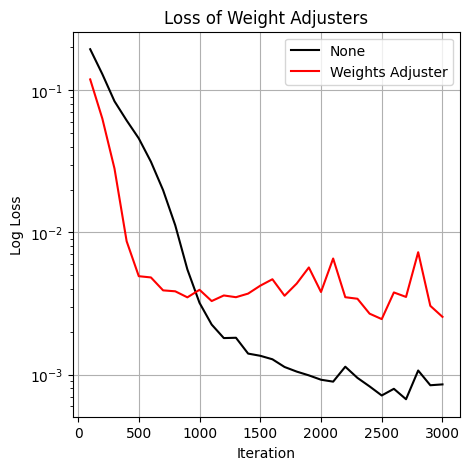

In [ ]:
import os
import pandas as pd

data_none = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/weights_adjuster/HL_2_A_Tanh()_N_20_avg_none.csv'))
data_weights = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/weights_adjuster/HL_2_A_Tanh()_N_20_avg_weights_adjuster.csv'))

plt.figure(figsize=(5, 5))
plt.plot(data_none['iteration'], data_none['loss'], label='None', c='black')
plt.plot(data_weights['iteration'], data_weights['loss'], label='Weights Adjuster', c='red')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.yscale('log')
plt.title('Loss of Weight Adjusters')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(os.getcwd(), 'docs', 'tests', 'weights_adjuster', 'weights_adjuster_loss.png'))
plt.show()

In [ ]:
plot_loss('out')

### Fine-tuning test 

In [11]:
def initial_condition_function_ft(x, epsilon1, epsilon2):
    return torch.sin(torch.pi * (torch.tensor(x) + epsilon1)) + epsilon2

def boundary_condition_function_ft(x, t, epsilon3):
    return torch.full_like(x, epsilon3)

# def boundary_condition_function_ft(x, t, epsilon3, epsilon4):
#     return torch.sin(torch.pi * torch.tensor(t + epsilon3)) + epsilon4

# Double check it
def analytical_solution_ft(x, t, alpha, L, epsilon1, epsilon2, epsilon3):
	"""
	u(x, 0) = sin(π(x + epsilon1)) + epsilon2
    u(0, t) = u(L, t) = epsilon3
    """
	x = torch.tensor(x)
	t = torch.tensor(t)
	u = torch.zeros_like(x)

	for n in range(1, 100):
		B_n, _ = quad(lambda x: (initial_condition_function_ft(x, epsilon1, epsilon2) - epsilon3) * np.sin(n * np.pi * x / L), 0, L)
		u += 2 / L * B_n * torch.sin(n * np.pi * x / L) * torch.exp(-alpha**2 * (n * np.pi / L)**2 * t)

	u += epsilon3
	return u

In [66]:
siren_params = siren.SirenParams(first_omega_0 = 30.0,
                                 hidden_omega_0 = 30.0,
                                 outermost_linear = True)

net_params = utils.NetParams()
net_params.set_params(input=2,
                      output=1,
                      hidden_layers=[int(64) for _ in range(1)],
                      epochs=10000,
                      batch_size=100,
                      lr=0.001,
                      activation='sin',
                      training_mode='train',
                      regularization='Elastic', # 'Lasso', 'Ridge', 'Elastic'
                      lambda_reg=0.01,
                      optimizer='Adam', # 'LBFGS', 'Adam' or 'Hybrid'
                      scheduler=None, # Not applicable with Hybrid optimizer
                      # 'StepLR', 'ExponentialLR', 'ReduceLROnPlateau' is supported
                      early_stopping=True, # Some problem
                      use_rar=False,
                      use_weights_adjuster=False,
                      display_interval=100,
                      model_save_path='models',
                      output_path='out',
                      save_loss=True,
                      initial_weights_path=None, # 'models/model_weights.pth'
                      siren_params=siren_params)

In [67]:
def save_results_to_csv(results, filename):
    keys = results.keys()
    with open(filename, 'w', newline='') as output_file:
        dict_writer = csv.DictWriter(output_file, keys)
        dict_writer.writeheader()
        dict_writer.writerows([dict(zip(keys, row)) for row in zip(*results.values())])

In [ ]:
epsilon1_values = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1]
epsilon2_values = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1]
epsilon3_values = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1]

results = defaultdict(list)
results_file = 'fine_tuning.csv'

for epsilon1 in epsilon1_values:
	for epsilon2 in epsilon2_values:
		for epsilon3 in epsilon3_values:
			if epsilon1 == epsilon2 == epsilon3 :
				print(f"Epsilon1: {epsilon1}, Epsilon2: {epsilon2}, Epsilon3: {epsilon3}")
				
				geom = geometry.Interval(0.0, 1.0)
				period = timedomain.TimeDomain(0.0, 0.5)
				
				initial_conditions = conditions.InitialConditions()
				initial_conditions.set_initial_conditions(geom=geom, time=period, 
														initial_func=lambda x: initial_condition_function_ft(x, epsilon1, epsilon2), 
														num_points=10000, random=False, device="cuda:0")

				boundary_conditions = conditions.BoundaryConditions()
				boundary_conditions.set_boundary_conditions(geom=geom, time=period, 
															boundary_func=lambda x, t: boundary_condition_function_ft(x, t, epsilon3), 
															num_points=10000, random=False, device="cuda:0")
				
				alpha = 0.5
				pde_heat = pde.PDE('heat', alpha=alpha)
				equation = conditions.Equation()
				equation.set_equation(pde=pde_heat, geom=geom, time=period, num_points=10000, random=False, device="cuda:0")

				test = conditions.Test()
				test.set_test(geom=geom, time=period, num_points=10000, random=False, device="cuda:0")

				problem = conditions.Problem(initial_conditions, boundary_conditions, 
											equation, test, geom, period, alpha=alpha)

				model = pinn.PINN(problem, net_params, device='cuda:0')
				time_start = time.time()
				model.train()
				time_end = time.time()
				print('Training time:', time_end - time_start)
				model.save_weights()
				
				x, t = problem.test.get_test()
				u_pinn = model.predict(x, t)

				solution_pinn = conditions.Solution()
				solution_pinn.set_solution(x, t, u_pinn)

				u_analytical = analytical_solution_ft(problem.test.x.cpu().detach().numpy(), 
												problem.period.t1, problem.alpha, 
												problem.geom.length(),
												epsilon1, epsilon2, epsilon3).to('cuda:0')
				solution_analytical = conditions.Solution()
				solution_analytical.set_solution(problem.test.x, problem.test.t, u_analytical)

				# Plot of solutions
				visualizations.comparison_plot(problem, solution_pinn, solution_analytical, net_params.output_path)

				# Plot loss
				visualizations.loss_history_plot(model.get_loss_history(), net_params.output_path)
				
				l2_norm = torch.sqrt(torch.sum((u_analytical - u_pinn)**2) / len(u_analytical)).item()
				print(f'L2 norm: {l2_norm}')

				results['time'].append(time_end - time_start)
				results['l2_norm'].append(l2_norm)
				results['epsilon1'].append(epsilon1)
				results['epsilon2'].append(epsilon2)
				results['epsilon3'].append(epsilon3)

				save_results_to_csv(results, results_file)

In [100]:
from sklearn.linear_model import LinearRegression

def plot_time_comparison(ax, data):
    data = data[data['epsilon'] != 0]
    font_size = 14
    
    log_epsilon = np.log10(data['epsilon']).values.reshape(-1, 1)
    
    reg_ft = LinearRegression().fit(log_epsilon, data['time_ft'])
    reg_zero = LinearRegression().fit(log_epsilon, data['time_zero'])
    
    epsilon_range = np.linspace(min(log_epsilon), max(log_epsilon), 100).reshape(-1, 1)
    time_ft_pred = reg_ft.predict(epsilon_range)
    time_zero_pred = reg_zero.predict(epsilon_range)
    
    ax.scatter(data['epsilon'], data['time_ft'], color='red', label='Время с дообучением')
    ax.plot(10**epsilon_range.flatten(), time_ft_pred, color='red', linestyle='-')
    
    ax.scatter(data['epsilon'], data['time_zero'], color='black', label='Время без дообучения')
    ax.plot(10**epsilon_range.flatten(), time_zero_pred, color='black', linestyle='-')
    
    ax.set_xlabel('log($\\varepsilon$)', fontsize=font_size)
    ax.set_ylabel('Время обучения t, с', fontsize=font_size)
    ax.set_title('Сравнение времени обучения с дообучением и без него', fontsize=font_size)
    ax.set_xscale('log')
    ax.legend()

In [107]:
def plot_time_vs_epsilon(finetuning_data, comparison_data):
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))
    epsilon_columns = ['epsilon1', 'epsilon2', 'epsilon3']
    epsilon_latex = ['$\\varepsilon_1$', '$\\varepsilon_2$', '$\\varepsilon_3$']
    font_size = 14
    
    for i, epsilon_x in enumerate(epsilon_columns):
        ax = axs[i // 2, i % 2]
        
        all_epsilon_x = finetuning_data[epsilon_x].values
        all_times = finetuning_data['time'].values
        
        ax.scatter(all_epsilon_x, all_times, color='black', marker='o')

        # Convert to numpy arrays for regression
        all_epsilon_x = np.array(all_epsilon_x).reshape(-1, 1)
        all_times = np.array(all_times)
        
        # Filter out infinities and large values
        valid_indices = np.isfinite(np.log(all_epsilon_x)).flatten() & np.isfinite(all_times)
        filtered_epsilon_x = all_epsilon_x[valid_indices]
        filtered_times = all_times[valid_indices]
        
        # Fit linear regression on log-transformed x
        log_filtered_epsilon_x = np.log(filtered_epsilon_x)
        reg = LinearRegression().fit(log_filtered_epsilon_x, filtered_times)
        time_pred = reg.predict(log_filtered_epsilon_x)
        
        # Sort values for plotting line
        sorted_indices = np.argsort(filtered_epsilon_x.flatten())
        sorted_epsilon_x = filtered_epsilon_x[sorted_indices]
        sorted_time_pred = time_pred[sorted_indices]
        
        # Plot linear regression line
        ax.plot(sorted_epsilon_x, sorted_time_pred, linestyle='--', color='red', label='Регрессия')
        
        ax.set_xlabel(f'log({epsilon_latex[i]})', fontsize=font_size)
        ax.set_ylabel('Время дообучения t, c', fontsize=font_size)
        ax.set_title(f'Зависимость времени дообучения от {epsilon_latex[i]}', fontsize=font_size)
        ax.tick_params(axis='both', which='major', labelsize=font_size)
        ax.set_xscale('log')
        ax.legend()
        
    plot_time_comparison(axs[1, 1], comparison_data)
    
    plt.tight_layout()
    plt.show()

In [108]:
fine_tuning_data = pd.read_csv('fine_tuning.csv')
fine_tuning_data = fine_tuning_data[fine_tuning_data['l2_norm'] < 1e-3]
comparison_data = pd.read_csv('comparison.csv')

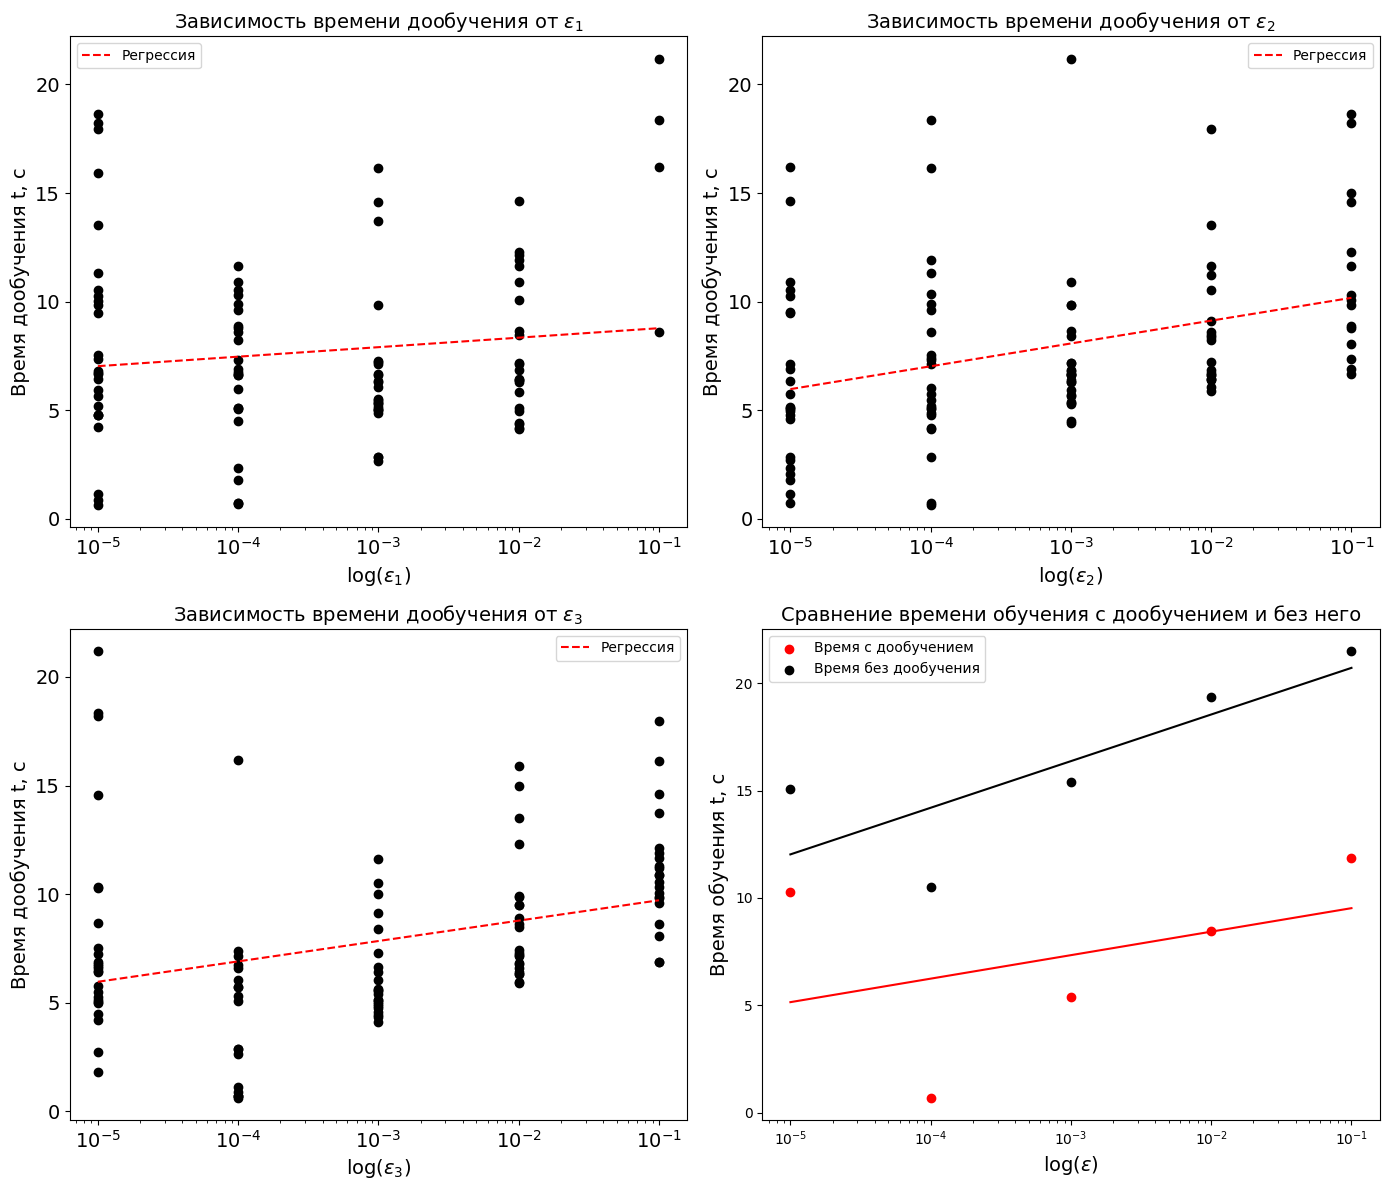

In [109]:
plot_time_vs_epsilon(fine_tuning_data, comparison_data)

### RAR

In [13]:
siren_params = siren.SirenParams(first_omega_0 = 30.0,
                                 hidden_omega_0 = 30.0,
                                 outermost_linear = True)

net_params = utils.NetParams()
net_params.set_params(input=2,
                      output=1,
                      hidden_layers=[int(32) for _ in range(1)],
                      epochs=10000,
                      batch_size=100,
                      lr=0.0001,
                      activation='sin',
                      training_mode='train',
                      regularization='Elastic', # 'Lasso', 'Ridge', 'Elastic'
                      lambda_reg=0.01,
                      optimizer='Adam', # 'LBFGS', 'Adam' or 'Hybrid'
                      scheduler=None, # Not applicable with Hybrid optimizer
                      # 'StepLR', 'ExponentialLR', 'ReduceLROnPlateau' is supported
                      early_stopping=False, # Some problem
                      use_rar=True,
                      use_weights_adjuster=False,
                      display_interval=100,
                      model_save_path='models',
                      output_path='out',
                      save_loss=True,
                      initial_weights_path=None, # 'models/model_weights.pth'
                      siren_params=siren_params)

In [14]:
model = pinn.PINN(problem, net_params, device='cuda:0')
model.training_mode
time_start = time.time()
model.train()
time_end = time.time()
print('Training time:', time_end - time_start)
model.save_weights()

1
Activation Function: Sin
Hidden Dimensions: 1
Number of neurons: 32
----------
Layer 0: SineLayer(
  (linear): Linear(in_features=2, out_features=32, bias=True)
) -> Linear
Layer 1: Linear(in_features=32, out_features=1, bias=True)
----------
Next number: 11
Oprtimizer: Adam
Iteration 100: Loss 0.4273322820663452
Iteration 200: Loss 0.3319768011569977
Iteration 300: Loss 0.26665183901786804
Iteration 400: Loss 0.21044141054153442
Iteration 500: Loss 0.16362960636615753
Iteration 600: Loss 0.12539206445217133
Iteration 700: Loss 0.09433411806821823
Iteration 800: Loss 0.06943050771951675
Iteration 900: Loss 0.04985206574201584
Iteration 1000: Loss 0.035261645913124084
Iteration 1100: Loss 0.024828316643834114
Iteration 1200: Loss 0.01759577915072441
Iteration 1300: Loss 0.012713535688817501
Iteration 1400: Loss 0.009420111775398254
Iteration 1500: Loss 0.007165426388382912
Iteration 1600: Loss 0.0055528441444039345
Iteration 1700: Loss 0.00436312286183238
Iteration 1800: Loss 0.003476

460.7527189254761 sec with RAR, loss 2.4635683075757697e-05 

63.6399245262146 sec without RAR, loss 3.779453254537657e-05 

10000 - > 11077

In [17]:
x_new = model.x_equation
t_new = model.t_equation
print(x_new.shape, t_new.shape)

torch.Size([11176, 1]) torch.Size([11176, 1])


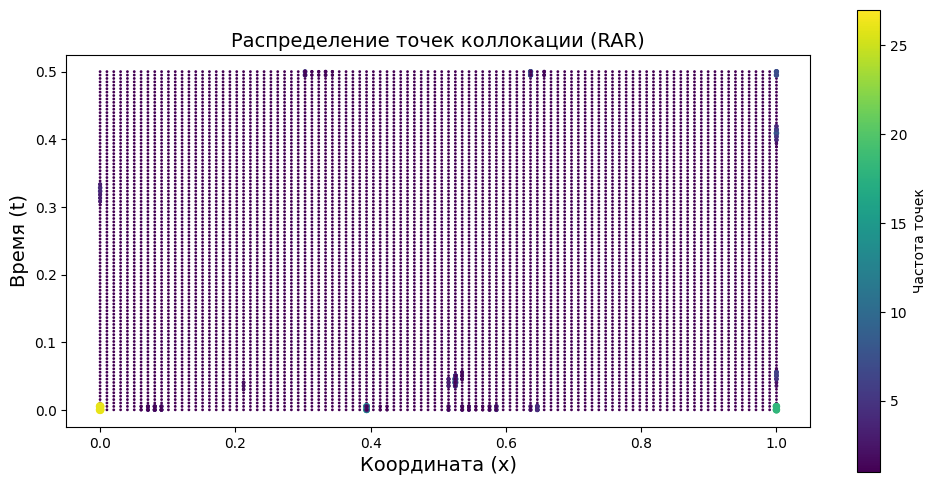

In [18]:
def visualize_rar_points(x_equation, t_equation, font_size=14):
    """
    Visualizes the distribution of RAR points.

    Parameters:
        x_equation (torch.Tensor): Tensor of spatial coordinates of collocation points.
        t_equation (torch.Tensor): Tensor of time coordinates of collocation points.
		font_size (int, optional): Font size for the plot. Defaults to 14.
    """
    
    x_np = x_equation.detach().cpu().numpy().flatten()
    t_np = t_equation.detach().cpu().numpy().flatten()

    # Создаем двумерную гистограмму для подсчета частоты точек
    points = list(zip(x_np, t_np))

    # Подсчитываем количество повторений каждого кортежа
    point_counts = Counter(points)

    # Разделяем данные для графика
    xpos = [point[0] for point in point_counts.keys()]
    ypos = [point[1] for point in point_counts.keys()]
    sizes = list(point_counts.values())

    # Строим график
    plt.figure(figsize=(12, 6))
    plt.scatter(xpos, ypos, s=sizes, c=sizes, cmap='viridis')
    plt.colorbar(label='Частота точек')
    plt.xlabel('Координата (x)', fontsize=font_size)
    plt.ylabel('Время (t)', fontsize=font_size)
    plt.title('Распределение точек коллокации (RAR)', fontsize=font_size)
    plt.axis('scaled')
    plt.show()

# Вызов функции для визуализации точек
visualize_rar_points(model.x_equation, model.t_equation, font_size=14)

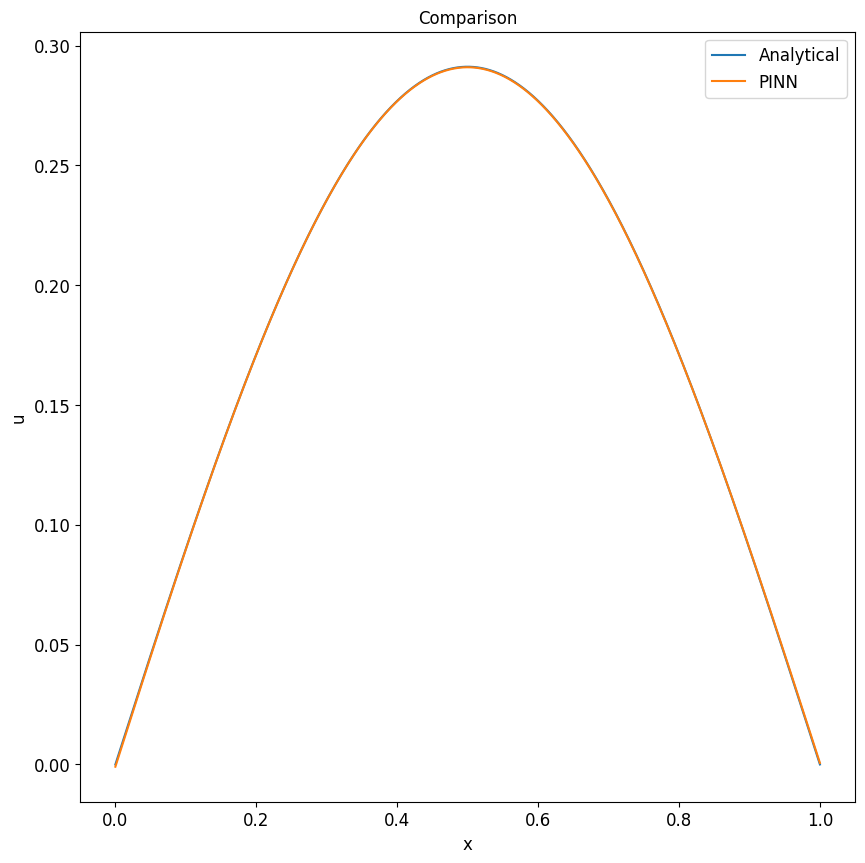

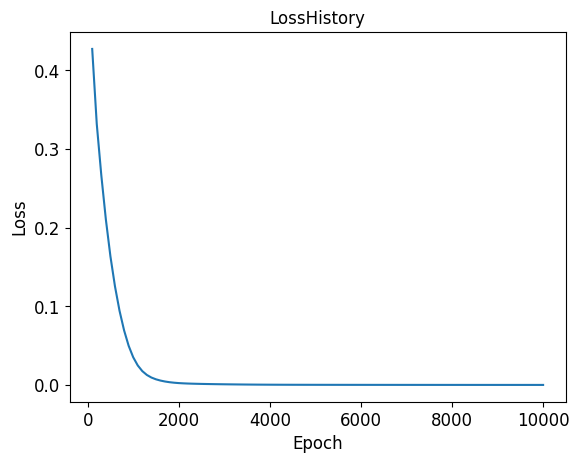

In [19]:
x, t = problem.test.get_test()
u_pinn = model.predict(x, t)

solution_pinn = conditions.Solution()
solution_pinn.set_solution(x, t, u_pinn)

u_analytical = analytical_solution(problem.test.x.cpu().detach().numpy(), 
                                   problem.period.t1, problem.alpha, 
                                   problem.geom.length()).to('cuda:0')
solution_analytical = conditions.Solution()
solution_analytical.set_solution(problem.test.x, problem.test.t, u_analytical)

# Plot of solutions
visualizations.comparison_plot(problem, solution_pinn, solution_analytical, net_params.output_path)

# Plot loss
visualizations.loss_history_plot(model.get_loss_history(), net_params.output_path)

L2 norm: 0.0004323209577705711


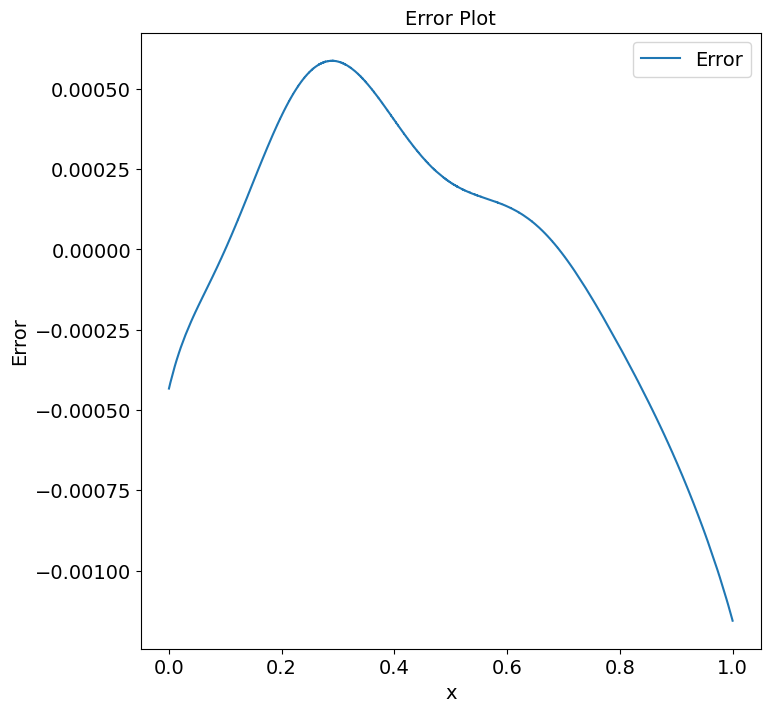

In [36]:
# L2 norm between analytical and PINN solutions
l2_norm = torch.sqrt(torch.sum((u_analytical - u_pinn)**2) / len(u_analytical))
print(f'L2 norm: {l2_norm}')

visualizations.error_plot(problem, solution_pinn, solution_analytical, net_params.output_path, font_size=14)

In [9]:
x, t = problem.test.get_test()
u_pinn = model.predict(x, t)
u_analytical = analytical_solution(problem.test.x.cpu().detach().numpy(), 
                                   problem.period.t1, problem.alpha, 
                                   problem.geom.length()).to('cuda:0')
error = metrics.calculate_error(u_analytical, u_pinn, is_abs=False)

In [20]:
x, t = problem.test.get_test()
u_pinn = model.predict(x, t)
u_analytical = analytical_solution(problem.test.x.cpu().detach().numpy(), 
                                   problem.period.t1, problem.alpha, 
                                   problem.geom.length()).to('cuda:0')
error_rar = metrics.calculate_error(u_analytical, u_pinn, is_abs=False)

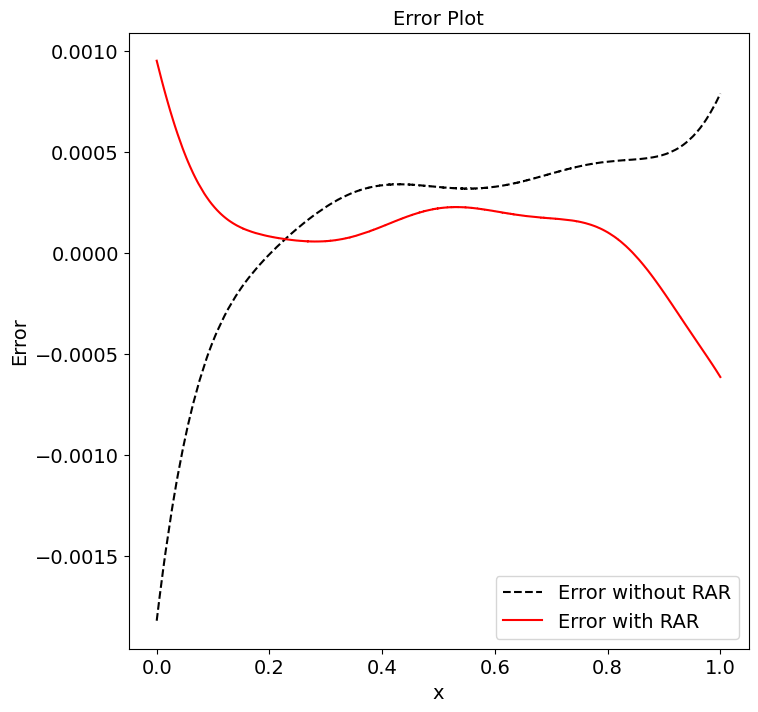

In [21]:
plt.figure(figsize=(8, 8))
font_size = 14

plt.plot(x.cpu().detach().numpy(), error.cpu().detach().numpy(), label='Error without RAR', linestyle='--', c='black')
plt.plot(x.cpu().detach().numpy(), error_rar.cpu().detach().numpy(), label='Error with RAR', c='r')

plt.ylabel('Error', fontsize=font_size)
plt.xlabel('x', fontsize=font_size)
plt.title('Error Plot', fontsize=font_size)
plt.legend(fontsize=font_size)
plt.tick_params(axis='both', which='major', labelsize=font_size)

### Regularization

In [ ]:
siren_params = siren.SirenParams(first_omega_0 = 30.0,
                                 hidden_omega_0 = 30.0,
                                 outermost_linear = True)

def run_training(runs):
    for i in range(runs):
        net_params = utils.NetParams()
        net_params.set_params(input=2,
                            output=1,
                            hidden_layers=[int(8) for _ in range(2)],
                            epochs=5000,
                            batch_size=100,
                            lr=0.0001,
                            activation='sin',
                            training_mode='train',
                            regularization='Elastic', # 'Lasso', 'Ridge', 'Elastic'
                            lambda_reg=0.01,
                            optimizer='Adam', # 'LBFGS', 'Adam' or 'Hybrid'
                            scheduler=None, # Not applicable with Hybrid optimizer
                            # 'StepLR', 'ExponentialLR', 'ReduceLROnPlateau' is supported
                            early_stopping=False, # Some problem
                            use_rar=False,
                            use_weights_adjuster=False,
                            display_interval=50,
                            model_save_path='models',
                            output_path='out',
                            save_loss=True,
                            initial_weights_path=None, # 'models/model_weights.pth'
                            siren_params=siren_params)
        
        model = pinn.PINN(problem, net_params, device='cuda:0')
        model.train()

In [ ]:
run_training(10)

Activation Function: Sin
Hidden Dimensions: 2
Number of neurons: 8
----------
Layer 0: SineLayer(
  (linear): Linear(in_features=2, out_features=8, bias=True)
) -> SineLayer
Layer 1: SineLayer(
  (linear): Linear(in_features=8, out_features=8, bias=True)
) -> Linear
Layer 2: Linear(in_features=8, out_features=1, bias=True)
----------
Next number: 0
Oprtimizer: Adam
Iteration 50: Loss 0.32260459661483765
Iteration 100: Loss 0.3312661945819855
Iteration 150: Loss 0.3307605981826782
Iteration 200: Loss 0.31223493814468384
Iteration 250: Loss 0.27824312448501587
Iteration 300: Loss 0.23609033226966858
Iteration 350: Loss 0.19228984415531158
Iteration 400: Loss 0.15304021537303925
Iteration 450: Loss 0.12223359197378159
Iteration 500: Loss 0.09939199686050415
Iteration 550: Loss 0.082858607172966
Iteration 600: Loss 0.07076231390237808
Iteration 650: Loss 0.061495840549468994
Iteration 700: Loss 0.053946252912282944
Iteration 750: Loss 0.04751173034310341
Iteration 800: Loss 0.0419706255197

In [ ]:
average_loss('out', 'HL_2_A_Sin()_N_8_', 'HL_2_A_Sin()_N_8_avg_regularization_Elastic.csv')

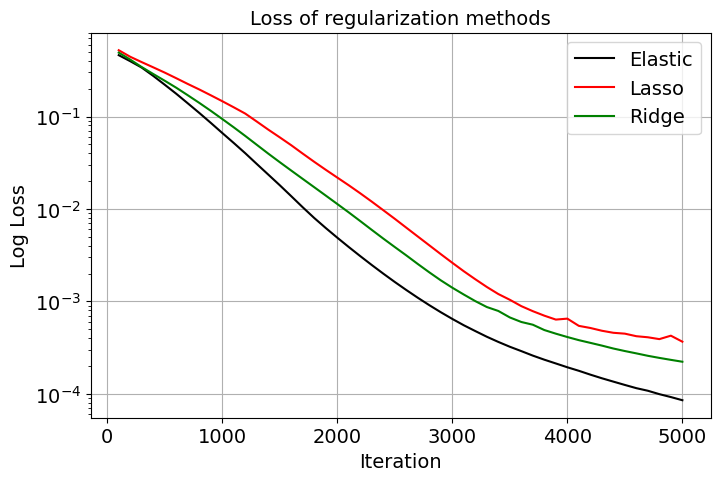

In [9]:
import os
import pandas as pd

data_elastic = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/regularizations/HL_2_A_Sin()_N_8_avg_regularization_Elastic.csv'))
data_lasso = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/regularizations/HL_2_A_Sin()_N_8_avg_regularization_Lasso.csv'))
data_ridge = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/regularizations/HL_2_A_Sin()_N_8_avg_regularization_Ridge.csv'))
font_size = 14

plt.figure(figsize=(8, 5))
plt.plot(data_elastic['iteration'], data_elastic['loss'], label='Elastic', c='black')
plt.plot(data_lasso['iteration'], data_lasso['loss'], label='Lasso', c='red')
plt.plot(data_ridge['iteration'], data_ridge['loss'], label='Ridge', c='green')
plt.xlabel('Iteration', fontsize=font_size)
plt.ylabel('Log Loss', fontsize=font_size)
plt.yscale('log')
plt.title('Loss of regularization methods', fontsize=font_size)
plt.legend(fontsize=font_size)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=font_size)
# plt.savefig(os.path.join(os.getcwd(), 'docs', 'tests', 'regularizations', 'regularization_loss.png'))
plt.show()

### Convergence animation

In [5]:
epochs_array = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 35, 40, 50, 60, 70]
siren_params = siren.SirenParams(first_omega_0 = 30.0,
									hidden_omega_0 = 30.0,
									outermost_linear = True)

for i in range(len(epochs_array)):
	print("Epochs: ", epochs_array[i])

	if i == 0:
		path = None
	else:
		path = f'models/HL_1_A_Sin()_N_64_{i-1}.pth'

	print("Path: ", path)
	
	net_params = utils.NetParams()
	net_params.set_params(input=2,
						output=1,
						hidden_layers=[int(64) for _ in range(1)],
						epochs=epochs_array[i],
						batch_size=100,
						lr=0.001,
						activation='sin',
						training_mode='train',
						regularization='Elastic', # 'Lasso', 'Ridge', 'Elastic'
						lambda_reg=0.01,
						optimizer='Adam', # 'LBFGS', 'Adam' or 'Hybrid'
						scheduler='StepLR', # Not applicable with Hybrid optimizer
						# 'StepLR', 'ExponentialLR', 'ReduceLROnPlateau' is supported
						early_stopping=True, # Some problem
						use_rar=True,
						use_weights_adjuster=False,
						display_interval=1,
						model_save_path='models',
						output_path='out',
						save_loss=True,
						initial_weights_path=path,
						siren_params=siren_params)

	model = pinn.PINN(problem, net_params, device='cuda:0')
	model.training_mode
	model.train()
	model.save_weights()

	# Delay in seconds
	time.sleep(5)

Epochs:  2
Path:  None
1
Activation Function: Sin
Hidden Dimensions: 1
Number of neurons: 64
----------
Layer 0: SineLayer(
  (linear): Linear(in_features=2, out_features=64, bias=True)
) -> Linear
Layer 1: Linear(in_features=64, out_features=1, bias=True)
----------
Next number: 0
Oprtimizer: Adam
Iteration 1: Loss 1.4054691791534424, Weighted Loss 5109.3623046875, Time 0.10349583625793457
Iteration 2: Loss 1.184117317199707, Weighted Loss 4720.125, Time 0.13692021369934082
Model weights saved to models
Epochs:  3
Path:  models/HL_1_A_Sin()_N_64_0.pth
1
Activation Function: Sin
Hidden Dimensions: 1
Number of neurons: 64
----------
Layer 0: SineLayer(
  (linear): Linear(in_features=2, out_features=64, bias=True)
) -> Linear
Layer 1: Linear(in_features=64, out_features=1, bias=True)
----------
Model weights loaded from models/HL_1_A_Sin()_N_64_0.pth
Next number: 1
Oprtimizer: Adam
Iteration 1: Loss 1.0583739280700684, Weighted Loss 4446.71337890625, Time 0.007429361343383789
Iteration 2

In [ ]:
weights = os.listdir('steps')

for i, weight in enumerate(weights):
	model.load_weights(os.path.join(os.getcwd(),'steps', weight))
	x = torch.linspace(0, 1, 100)
	t = torch.linspace(0, 0.5, 100)
	x, t = torch.meshgrid(x, t)
	x = x.reshape(-1, 1).to('cuda:0')
	t = t.reshape(-1, 1).to('cuda:0')

	u_pinn = model.predict(x, t)

	solution_pinn = conditions.Solution()
	solution_pinn.set_solution(x, t, u_pinn)

	# Surface plot
	visualizations.solution_surface_plot(problem, solution_pinn, f'{i}')

In [8]:
from PIL import Image, ImageSequence
import imageio

image_folder = os.path.join(os.getcwd(), 'steps', 'pic')
gif_path = os.path.join(os.getcwd(), 'steps', 'animation.gif')
images = []

# Считывание изображений из папки 'steps/pic'
image_files = sorted(os.listdir(image_folder))
for image in image_files:
    temp_image_path = os.path.join(image_folder, image)
    images.append(Image.open(temp_image_path))

# Создание GIF с увеличенным временем показа каждого кадра
frame_duration = 500  # длительность показа одного кадра в миллисекундах

images[0].save(gif_path, save_all=True, append_images=images[1:], duration=frame_duration, loop=0)

print(f'GIF сохранен в {gif_path}')

GIF сохранен в c:\Users\alex\Documents\GitHub\PINN\steps\animation.gif


## Debug

In [178]:
siren_params = siren.SirenParams(first_omega_0 = 30.0,
                                 hidden_omega_0 = 30.0,
                                 outermost_linear = True)

net_params = utils.NetParams()
net_params.set_params(input=2,
                      output=1,
                      hidden_layers=[int(64) for _ in range(1)],
                      epochs=150,
                      batch_size=100,
                      lr=0.001,
                      activation='sin',
                      training_mode='train',
                      regularization='Elastic', # 'Lasso', 'Ridge', 'Elastic'
                      lambda_reg=0.01,
                      optimizer='Adam', # 'LBFGS', 'Adam' or 'Hybrid'
                      scheduler='StepLR', # Not applicable with Hybrid optimizer
                      # 'StepLR', 'ExponentialLR', 'ReduceLROnPlateau' is supported
                      early_stopping=True, # Some problem
                      use_rar=True,
                      use_weights_adjuster=False,
                      display_interval=100,
                      model_save_path='models',
                      output_path='out',
                      save_loss=True,
                      initial_weights_path=None, # 'models/model_weights.pth'
                      siren_params=siren_params)

# TODO: Early stopping not work correctly
# Or load from json file
# net_params.from_json_file("params.json")

In [179]:
model = pinn.PINN(problem, net_params, device='cuda:0')
model.training_mode
model.train()
model.save_weights()

1
Activation Function: Sin
Hidden Dimensions: 1
Number of neurons: 64
----------
Layer 0: SineLayer(
  (linear): Linear(in_features=2, out_features=64, bias=True)
) -> Linear
Layer 1: Linear(in_features=64, out_features=1, bias=True)
----------
Next number: 1
Oprtimizer: Adam
Iteration 100: Loss 0.17327289283275604, Weighted Loss 201.49957275390625, Time 0.9273946285247803
Model weights saved to models


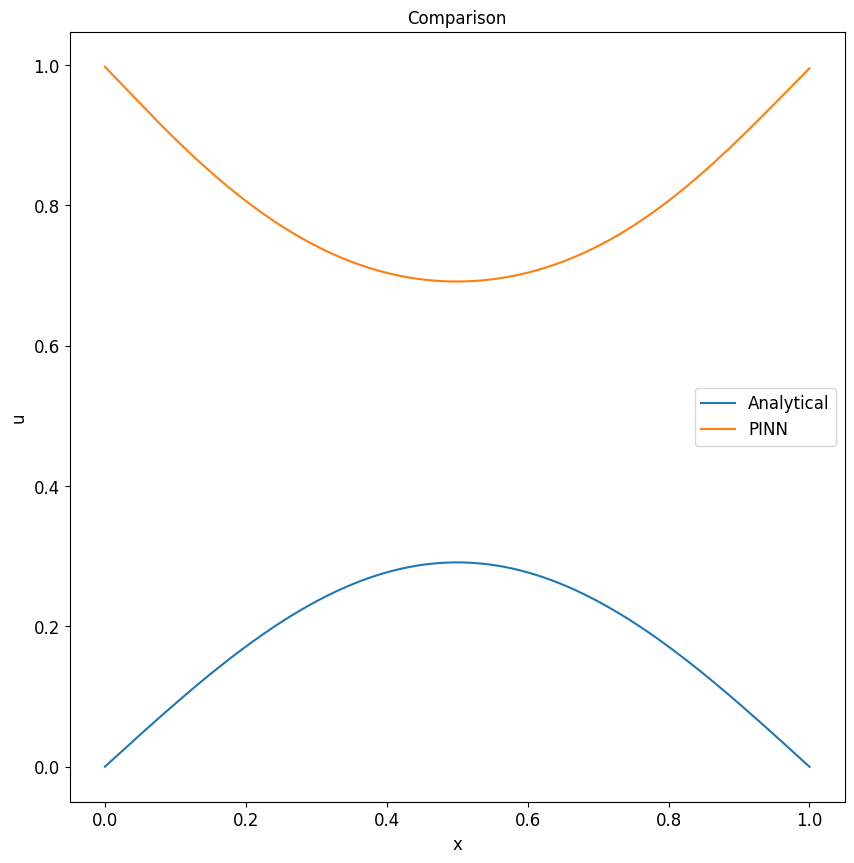

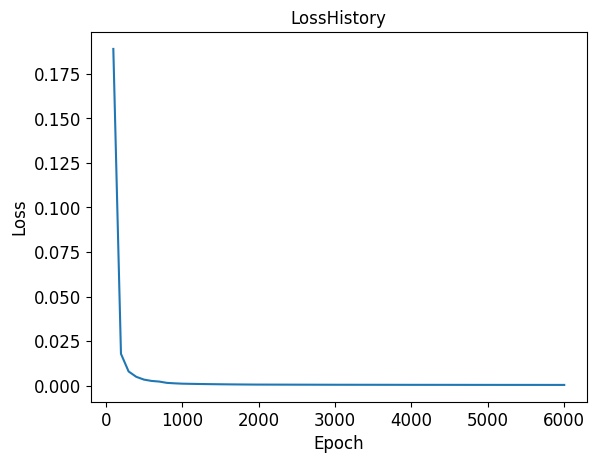

In [141]:
x, t = problem.test.get_test()
u_pinn = model.predict(x, t)

solution_pinn = conditions.Solution()
solution_pinn.set_solution(x, t, u_pinn)

u_analytical = analytical_solution(problem.test.x.cpu().detach().numpy(), 
                                   problem.period.t1, problem.alpha, 
                                   problem.geom.length()).to('cuda:0')
solution_analytical = conditions.Solution()
solution_analytical.set_solution(problem.test.x, problem.test.t, u_analytical)

# Plot of solutions
visualizations.comparison_plot(problem, solution_pinn, solution_analytical, net_params.output_path)

# Plot loss
visualizations.loss_history_plot(model.get_loss_history(), net_params.output_path)

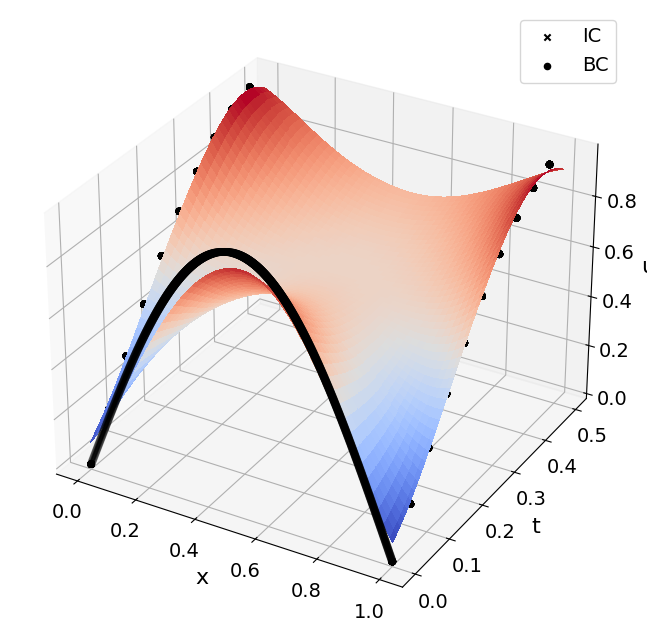

In [148]:
x = torch.linspace(0, 1, 100)
t = torch.linspace(0, 0.5, 100)
x, t = torch.meshgrid(x, t)
x = x.reshape(-1, 1).to('cuda:0')
t = t.reshape(-1, 1).to('cuda:0')

u_pinn = model.predict(x, t)

solution_pinn = conditions.Solution()
solution_pinn.set_solution(x, t, u_pinn)

# Surface plot
visualizations.solution_surface_plot(problem, solution_pinn, net_params.output_path)

L2 norm: 0.00023276741558220237


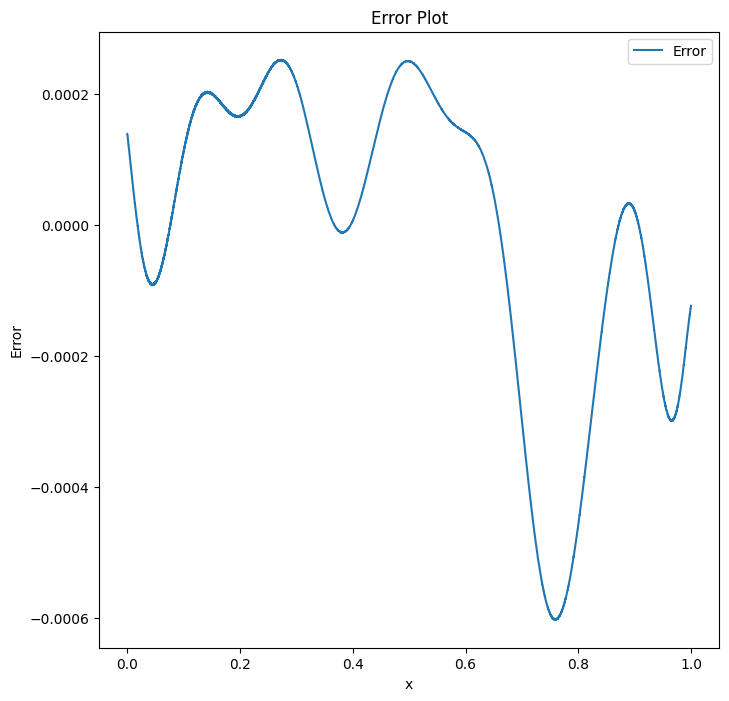

In [11]:
# L2 norm between analytical and PINN solutions
l2_norm = torch.sqrt(torch.sum((u_analytical - u_pinn)**2) / len(u_analytical))
print(f'L2 norm: {l2_norm}')

visualizations.error_plot(problem, solution_pinn, solution_analytical, net_params.output_path)